In [1]:
! pip install -q vietocr
! pip install -q ultralytics
! pip install -q supervision

In [2]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import string
import supervision as sv
from ultralytics import YOLO
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
import warnings
warnings.filterwarnings('ignore')

In [3]:
class InferenceOCR:
  def __init__(self, detection_model = None, ocr_model = None):
    self.detection_model = detection_model
    self.ocr_model = ocr_model
    self.id2label = detection_model.names

  def inference_detection(self, image, confidence = 0.5):
    detections = self.detection_model.predict(image, conf = confidence)
    detection_result = sv.Detections.from_ultralytics(detections[0])
    detection_result = detection_result.with_nms(threshold = 0.5)
    return detection_result


  def crop_picture(self, image, box):
    return image[box[1]:box[3], box[0]:box[2]]

  def inference_ocr(self, image):
    output = self.ocr_model.predict(image)
    return output

  def predict(self, image, detection_confidence = 0.5):
    date_fields = [2, 6, 9]
    detections = self.inference_detection(image, confidence = detection_confidence)
    df = pd.DataFrame()
    df[["x1", "y1", "x2", "y2"]] = detections.xyxy
    df["class"] = detections.class_id
    text = []
    for box in detections.xyxy:
      box = np.round(box).astype(int)
      cropped = self.crop_picture(image, box)
      ocr_res = self.ocr_model.predict(Image.fromarray(cropped))
      text.append(ocr_res)
    df["text"]  = text
    output = {}
    for class_id in df["class"].unique():
      df_class = df[df["class"] == class_id]

      # line determination:
      max_height = (df_class["y2"] - df_class["y1"]).max()
      line = df_class["y2"].max() - max_height* 1.25
      df_class["line"] = df_class.apply(lambda row: 1 if row["y1"] <= line else 2, axis=1)
      df_class = df_class.sort_values(["class", "line", "x1"], ascending = [True, True, True])

      # text post processing
      output_text = " ".join([i for i in df_class["text"]])
      if class_id == 0:
        regex = re.compile(r'[^0-9]')
        output_text = regex.sub('', output_text)
      elif class_id in date_fields:
        regex = re.compile(r'[^0-9/\' ]')
        output_text = regex.sub('', output_text)

      output[class_id] = output_text.strip()
    return output



In [4]:
detection_model = YOLO("/content/drive/MyDrive/CCCD PROJECT/ultralytics/runs/detect/train/weights/best.pt")

config = Cfg.load_config_from_name('vgg_transformer')
config['cnn']['pretrained']=False
config['device'] = 'cpu'
ocr_model = Predictor(config)

inference = InferenceOCR(detection_model = detection_model, ocr_model = ocr_model)

Model weight /tmp/vgg_transformer.pth exsits. Ignore download!


# Demo

(-0.5, 655.5, 396.5, -0.5)

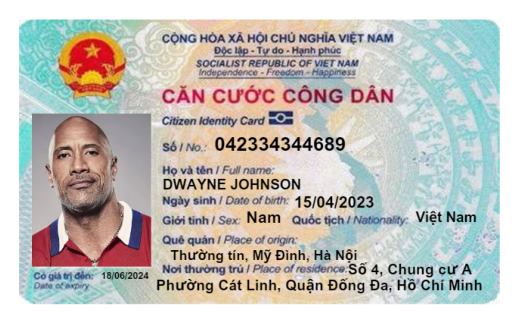

In [5]:
image_path = "/content/drive/MyDrive/CCCD PROJECT/Test_CCCD.png"
image_data = cv2.imread(image_path)
image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
plt.imshow(image_data)
plt.axis("off")

In [6]:
detection_output = inference.inference_detection(image_data)
ocr_output = inference.predict(image_data, detection_confidence = 0.5)



0: 416x640 1 ID, 2 Names, 1 Dob, 1 Sex, 2 Nats, 6 Hometowns, 2 Does, 14 Addresss, 574.1ms
Speed: 13.0ms preprocess, 574.1ms inference, 13.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 ID, 2 Names, 1 Dob, 1 Sex, 2 Nats, 6 Hometowns, 2 Does, 14 Addresss, 525.1ms
Speed: 5.8ms preprocess, 525.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


In [7]:
box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = box_annotator.annotate(
    image_data.copy(), detections=detection_output)

ID: 04234344689
Name: DWAYNE JOHNSON
Dob: 15/04/2023
Sex: Nam
Nat: Việt Nam
Hometown: Thường tín, Mỹ Đình; Hà Nội
Doe: 18/06/2024
Address: Số 4 Chung cư A Phường Cát Linh, Quận Đống Đa; Hồ Chi Minh


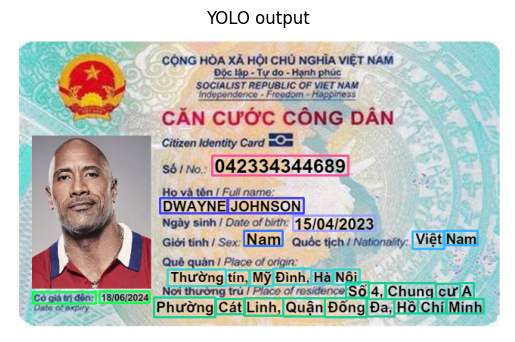

In [9]:
plt.imshow(annotated_frame)
plt.title("YOLO output")
plt.axis("off")
id2label = detection_model.names
keys = set(id2label.keys()) & set(ocr_output.keys())

for i in keys:
  print(f"{id2label[i]}: {ocr_output[i]}")